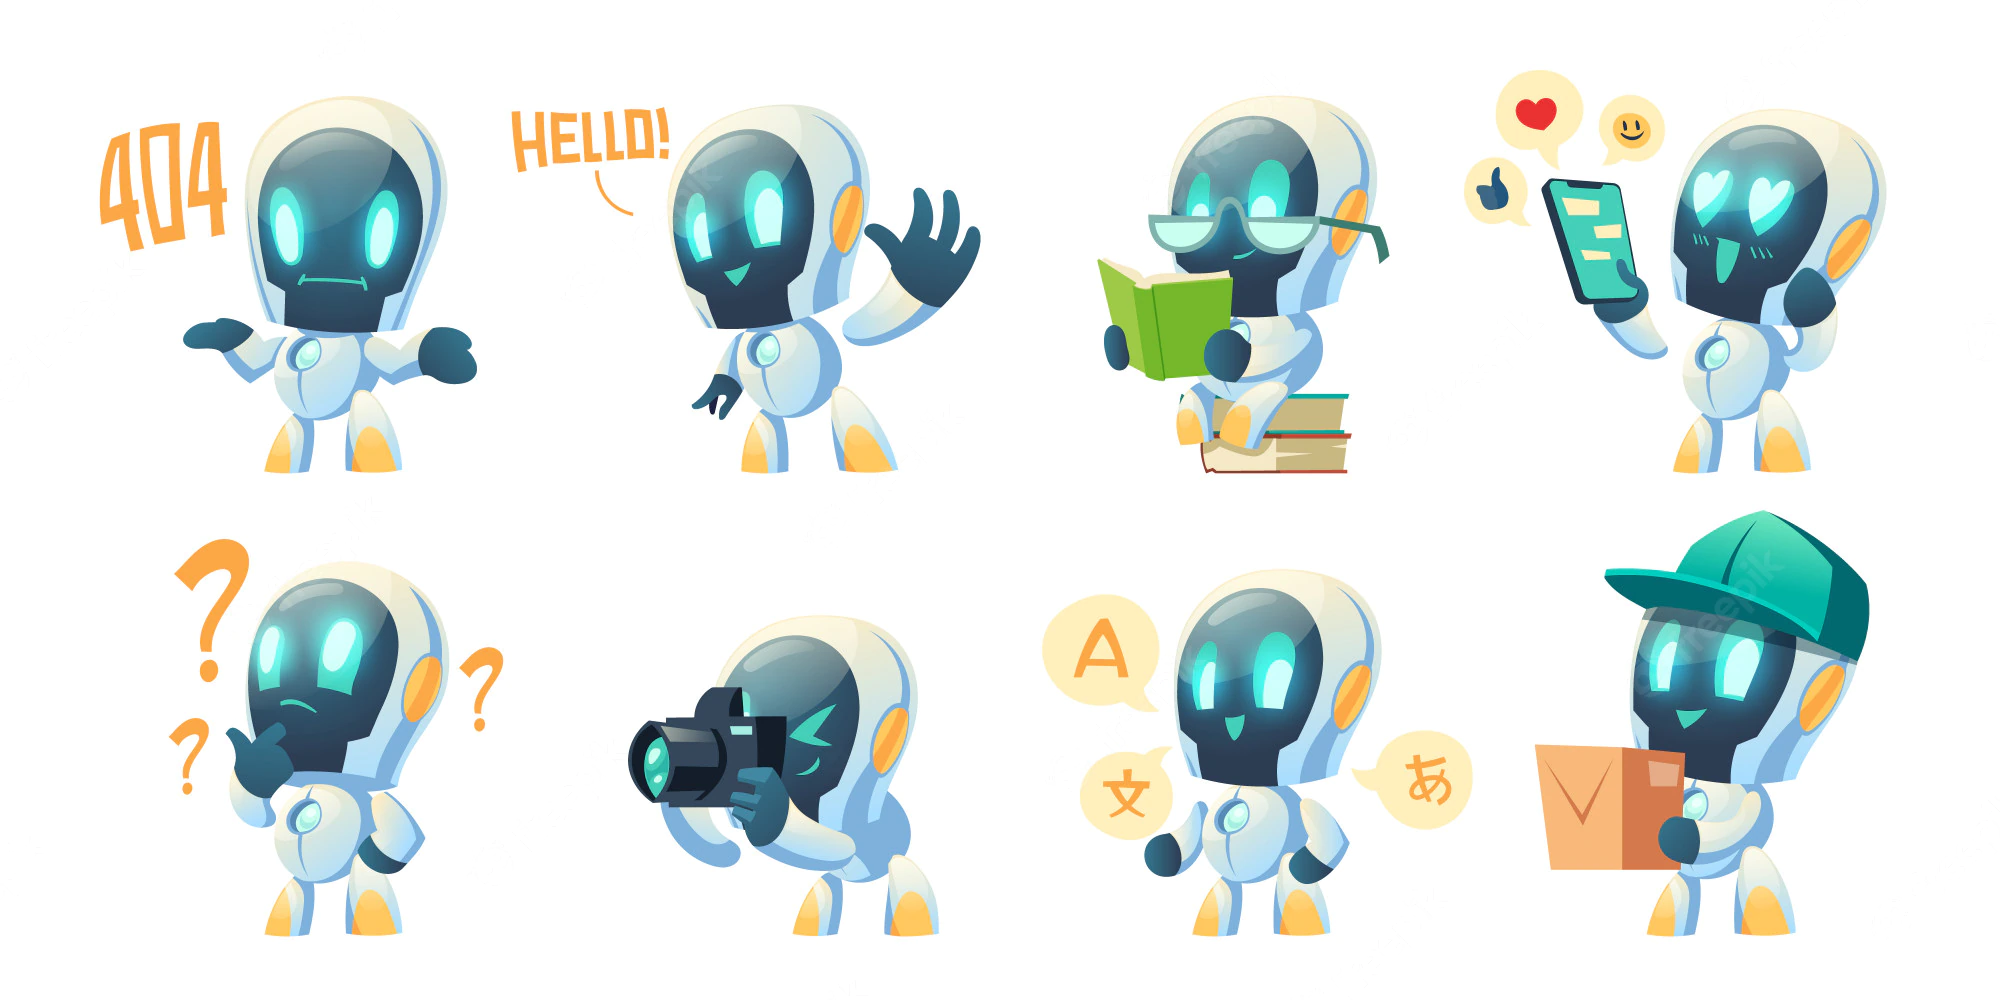

# **Chatbot Project**

## Data Processing

In [ ]:
pip install nltk

In [ ]:
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import json
import pickle
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random

lemmatizer = WordNetLemmatizer()
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
# read data and covert to dict
data_file = open('intents.json').read()
intents = json.loads(data_file)

for intent in intents['intents']:
    for pattern in intent['patterns']:
      # split every single word
        w = nltk.tokenize.word_tokenize(pattern)
        # add each word to list
        words.extend(w)
        # add words and it's tag together
        documents.append((w, intent['tag']))
        #create classes this what we gonna use like ouput(y_train) later
        if intent['tag'] not in classes:
            classes.append(intent['tag'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# THIS FOR CREATE LOWERCASE FOR ALL LETTER
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
# SORT IT
words = sorted(words)
classes = sorted(classes)
# SAVE IT
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

## Create Train/Test set

NOW we will create X_train y_train

In [ ]:
training = []
output_empty = [0] * len(classes)
for doc in documents:
    bag = []
    # this is words that we gonna use to chat with bot
    pattern_words = doc[0]
    # so lowercase it also
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

    for w in words:
      # create X_train in onehot vector shape
        bag.append(1) if w in pattern_words else bag.append(0)
      # this is for y_train
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    # full training set
    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training)

In [ ]:
X_Train = list(training[:,0])
y_train = list(training[:,1])

Build Basic Model ANN

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(len(X_Train[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(y_train[0]), activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               24064     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                 585       
                                                                 
Total params: 32,905
Trainable params: 32,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
hist = model.fit(np.array(X_Train), np.array(y_train), epochs=200, batch_size=5, verbose=1)

It's hight accuracy

## Save model and test

In [ ]:
model.save('chatbot_model.h5', hist)

In [ ]:
import pandas as pd 
df_hist = pd.DataFrame(hist.history)

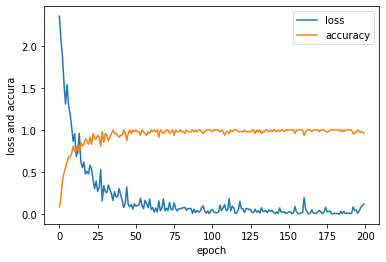

In [ ]:
ax = df_hist.plot()
ax.set_xlabel('epoch')
ax.set_ylabel('loss and accura');

Two function below is just processing our input words to make predict

In [ ]:
def test(pattern):
  bag = []
  pattern_words = nltk.tokenize.word_tokenize(pattern)
  pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
  for w in words:
      bag.append(1) if w in pattern_words else bag.append(0)
  return np.array([bag])


In [ ]:
def chatbot_response(msg):
    y_hat = model.predict(test(msg))
    class_predicted = np.argmax(y_hat,axis=1)
    class_predicted= classes[int(np.argmax(y_hat,axis=1))]
    for intent in intents['intents']:
        if class_predicted == intent['tag']:
            res = random.choice(intent['responses'])
            break
    return res

In [ ]:
asking = 'How you could help me'
chatbot_response(asking)

'Offering support for Adverse drug reaction, Blood pressure, Hospitals and Pharmacies'

**Done Donee!**